# Basic Calcium Imaging Pipeline Using PCA-ICA
### Example with 4 rat videos
Importing Libraries and Videos for Data Analysis:

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os  # operating system
from glob import glob
from pathlib import Path  # to work with directories

import isx  # Inscopix API
import matplotlib.pyplot as plt  # data visualization
import numpy as np  # to manipulate data matrix
import pandas as pd  # data analysis library
import seaborn as sns
import cgk_calcium_tools as cct
from cgk_calcium_tools import isx_files_handler
from cgk_calcium_tools import plot_grid_max_dff_and_cellmap_fh
from scipy import stats  # statistics library

In [3]:
sns.set_style("darkgrid")


outputsfolder = r'H:\D1838_example'  #it could be a list
#files_list_log = r'H:\D1838_example\\logD1_838.json'  #it could be a list

mainfolder = [r'\\CGK_NAS\Calcium Imaging Data\Rats\Calcium Imaging-MUSC Rats\Cohort 1']*4 #it could be a list


data_subfolder = r'D1-838/D1-838_StressDay_10121' #it could be a list

sns.set_style("darkgrid")

# the videos are saved in folders based the animal id and the day when the videos were recorded
files_patterns = [
    '2021-10-01-11-27-26_video_trig_0.isxd', 
    '2021-10-01-12-07-09_video_trig_0.isxd', 
    '2021-10-01-13-42-25_video_trig_0.isxd', 
    '2021-10-01-14-14-37_video_trig_0.isxd'
]

animal_sessions = { 
    #a key for each animal
    'D1-838': ['P1','S1','S2','P2'] #sessions in the same order as the files
}

#the next lines creates lists with the cell type and other metadata for each file using our naming convention and animal_sessions 
metadata = []
for cell_animal,sessions in animal_sessions.items():
    for session in sessions:
       metadata.append({
            "rat_ID":cell_animal[3:],
            "session_name":session,
            'Recording Label': cell_animal + '_' + session,
            "cell_type": cell_animal[:2],
            "Day": 21 #just an example
       })

metadata = pd.DataFrame(metadata)

fh = isx_files_handler(main_data_folder=mainfolder,
        outputsfolders=outputsfolder,
        data_subfolders=data_subfolder,
        files_patterns=files_patterns,
        processing_steps=["PP","TR", "BP", "MC"],
        recording_labels = metadata['Recording Label'].to_list())
        #files_list_log=files_list_log)

video_len_seconds = int(29.5 * 60)  # setting the length of the video

In [10]:
# create a table with video metadata
df_vd=cct.get_movies_info(fh.rec_paths)


Checking the length of videos

In [4]:
df_vd["Duration (s)"] > video_len_seconds

Full Path
\\CGK_NAS\Calcium Imaging Data\Rats\Calcium Imaging-MUSC Rats\Cohort 1\D1-838\D1-838_StressDay_10121\2021-10-01-11-27-26_video_trig_0.isxd    True
\\CGK_NAS\Calcium Imaging Data\Rats\Calcium Imaging-MUSC Rats\Cohort 1\D1-838\D1-838_StressDay_10121\2021-10-01-12-07-09_video_trig_0.isxd    True
\\CGK_NAS\Calcium Imaging Data\Rats\Calcium Imaging-MUSC Rats\Cohort 1\D1-838\D1-838_StressDay_10121\2021-10-01-13-42-25_video_trig_0.isxd    True
\\CGK_NAS\Calcium Imaging Data\Rats\Calcium Imaging-MUSC Rats\Cohort 1\D1-838\D1-838_StressDay_10121\2021-10-01-14-14-37_video_trig_0.isxd    True
Name: Duration (s), dtype: bool

Trimming the videos to the same length 

In [5]:
fh.de_interleave(False)
fh.run_step('PP',spatial_downsample_factor=1)

de_interleaving movies, please wait...
done
Preprocessing movies, please wait...
done


This Cell preprocesses the videos and apply a spatial filter.
Preprocessing removes artifacts from the videos and reduces the size of the videos.
The Spatial filter removes the low and high frequency contents (removes noise).


In [6]:
fh.run_step('TR',video_len=video_len_seconds)
fh.run_step('BP')
fh.run_step('MC')

Trim movies...
done
Applying bandpass filter, please wait...
done
Applying motion correction. Please wait...
done


DeltaF/F0 normalizes the pixel values in the movies so that the variation in intensity is not due to spatial variation.

In [7]:
fh.create_dff()
fh.project_movie()

done
done


### Cell extraction 

This step has multiple dictionaries as inputs, to set the parameters for cell extraction (depending of the algorithm used), event detection, auto_accept_reject and multiplane_registration (if required).

The PCA-ICA algorithm identifies the spatial location of cells in the video and their associated activity using the principal and independent components of the video.

Event Detection allows cells to be identified when they have an activity

This filters accepted cells based on different cell critiaer

In [8]:
fh.extract_cells('pca-ica',cells_extr_params = {'num_pcs':50}, detection_params={'threshold':4})

done


Shows the cellmaps for the accepted cells

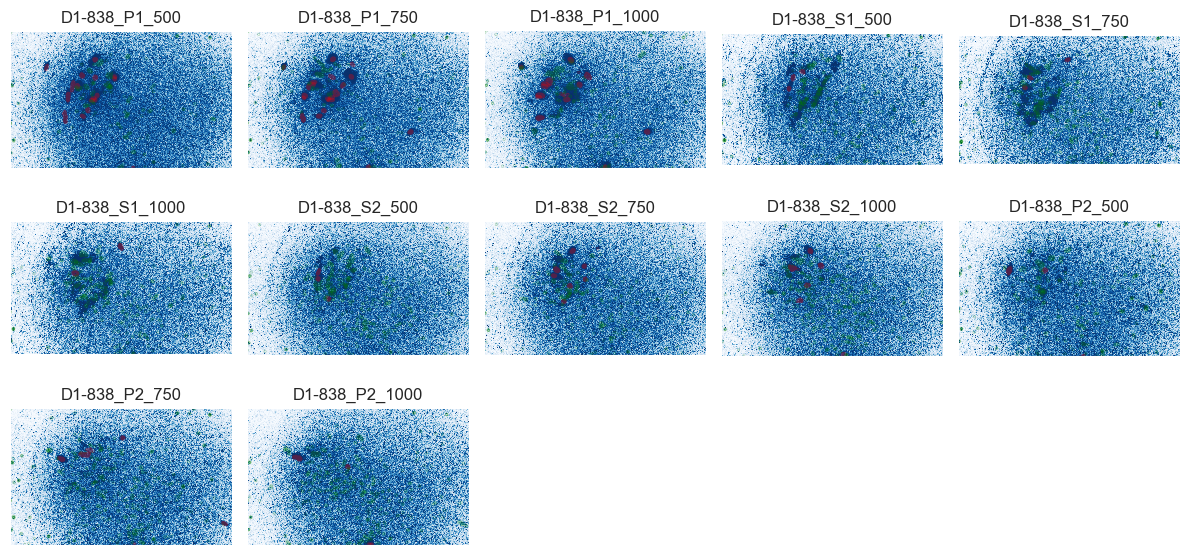

In [9]:
plot_grid_max_dff_and_cellmap_fh(
        fh,
        eqhist=True,
        cellsetname="pca-ica",
        before_registration=True,
        status_list=["accepted", "rejected", "undecided"],
        colors=['red','green', 'black'],
        figsize = (12,6))


In [10]:
cellsets_df= cct.get_cellset_info(fh, cellset_name="pca-ica")
events_df = cct.get_eventset(fh,cellsetname="pca-ica", accepted_only = True)
firing_rates_df = cct.compute_firing_rates(events_df,cellsets_df)


Example of bar graph to plot firing rate

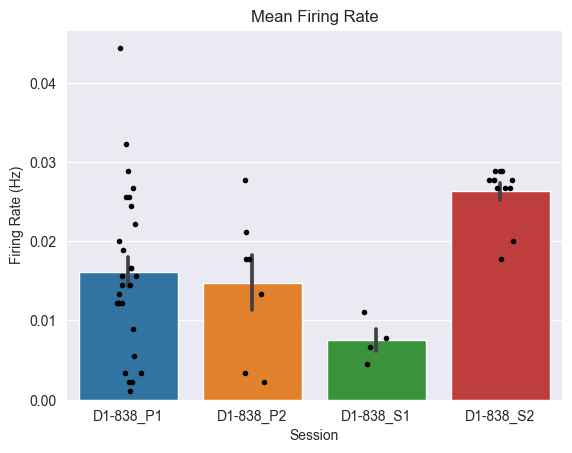

In [11]:
ax = sns.barplot(data=firing_rates_df, x='Recording Label', y='Firing Rate (Hz)', errorbar="se")
plt.title("Mean Firing Rate")

sns.stripplot(
    x='Recording Label', y='Firing Rate (Hz)', data=firing_rates_df, ax=ax,color='black',
    size=4,legend=False,dodge=True
)
plt.xlabel("Session"); #This helps to rename axis

In [17]:
firing_rates_df=firing_rates_df.merge(metadata, how='left', on='Recording Label')

In [28]:
import itertools
from scipy.stats import ranksums
cats=list(itertools.product(firing_rates_df['cell_type'].unique(), firing_rates_df['session_name'].unique()))

min_p_show = 0.07

for (ct1,sn1), (ct2,sn2) in itertools.combinations(cats, 2):
    sel1 = firing_rates_df[(firing_rates_df.cell_type==ct1) & (firing_rates_df.session_name==sn1)]['Firing Rate (Hz)'].values
    
    sel2 = firing_rates_df[(firing_rates_df.cell_type==ct1) & (firing_rates_df.session_name==sn2)]['Firing Rate (Hz)'].values

    s,p = ranksums(sel1, sel2)
    
    if p <=min_p_show:
        print("{} {} vs {} {}: {:e}".format(cats[i][0],cats[i][1],cats[j][0], cats[j][1],p ))

ids = np.unique(firing_rates_df['rat_ID'])
print('stressday: ')
print('Animals ({}): {}'.format(len(ids),ids))
print('neurons: {}'.format(len(firing_rates_df)))

D1 S2 vs D1 S2: 6.824749e-02
D1 S2 vs D1 S2: 4.204063e-04
D1 S2 vs D1 S2: 6.840858e-03
D1 S2 vs D1 S2: 3.609347e-03
stressday: 
Animals (1): ['838']
neurons: 51


In [29]:
s,p = ranksums([], [])

C:\Users\user\anaconda3\envs\isxenv\lib\site-packages\scipy\stats\_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


In [19]:
firing_rates_df[['Recording Label,cell_name']]

,Recording Label,cell_name,#events,Firing Rate (Hz),rat_ID,session_name,cell_type,Day
0,D1-838_P1,C00,2,0.002223,838,P1,D1,21
1,D1-838_P1,C01,3,0.003334,838,P1,D1,21
2,D1-838_P1,C02,13,0.014446,838,P1,D1,21
3,D1-838_P1,C03,13,0.014446,838,P1,D1,21
4,D1-838_P1,C04,17,0.018891,838,P1,D1,21
5,D1-838_P1,C05,5,0.005556,838,P1,D1,21
6,D1-838_P1,C06,26,0.028893,838,P1,D1,21
7,D1-838_P1,C07,15,0.016669,838,P1,D1,21
8,D1-838_P1,C08,23,0.025559,838,P1,D1,21
9,D1-838_P1,C09,29,0.032226,838,P1,D1,21


In [18]:
metadata

,rat_ID,session_name,Recording Label,cell_type,Day
0,838,P1,D1-838_P1,D1,21
1,838,S1,D1-838_S1,D1,21
2,838,S2,D1-838_S2,D1,21
3,838,P2,D1-838_P2,D1,21


Calculates the cumulative events over each session

Using the compute_acumulated function, it's possible to compute the accumulated events based on the events and cellsets_dt, where the latter contains the necessary data about the recording duration..

In [12]:
cum_events_df = cct.compute_acumulated(events_df, cellsets_df)

In [13]:
cum_events_df=cum_events_df.merge(metadata, how='left', on='Recording Label')

In [16]:
import isx
isx.__version__

'1.9.2.3727'

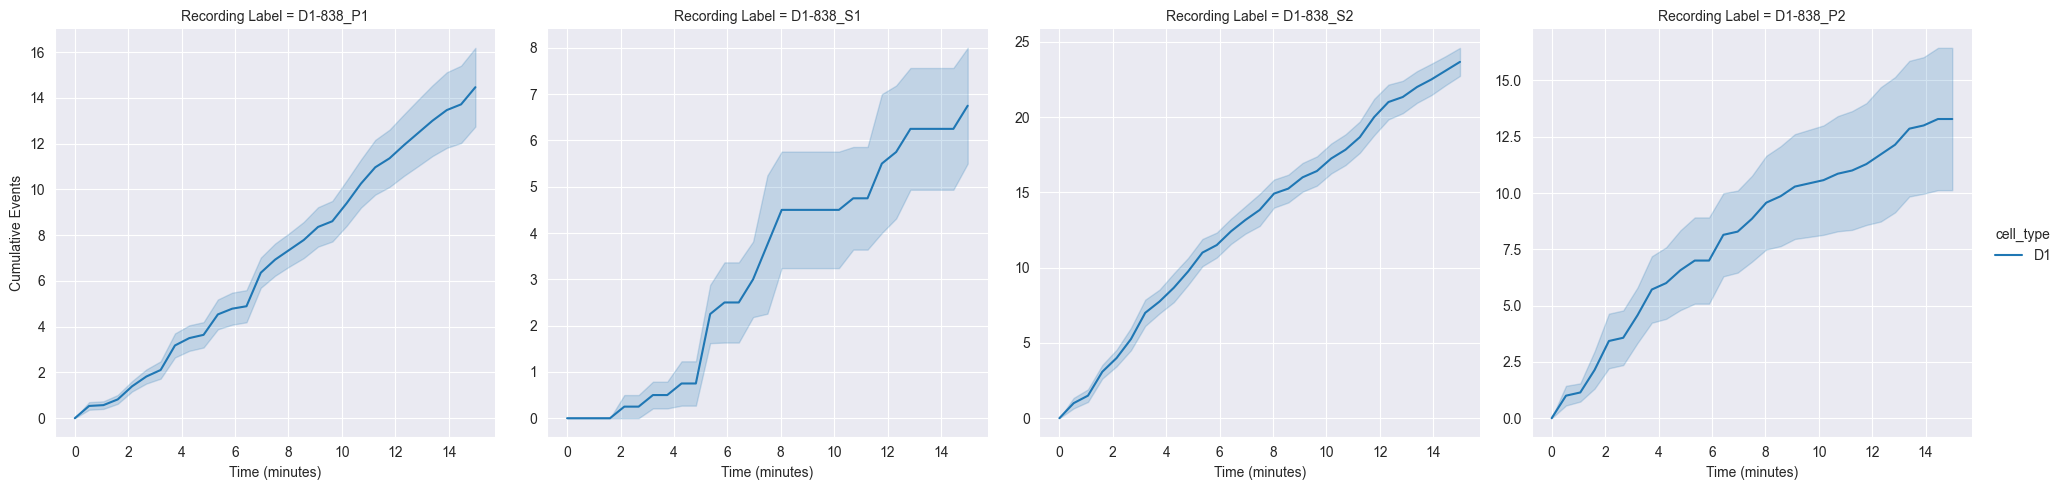

In [14]:
sns.relplot(x="Time (minutes)", y='Cumulative Events',
             hue="cell_type", col='Recording Label',
             data=cum_events_df,kind='line',facet_kws={'sharey': False},errorbar='se')

Creates a plot of the cell traces

In [15]:
# Hi malika I'm still working on how to get in a nice way the traces...

assert False, 'Work in progress'
plt.figure(figsize=(20, 12))
for fi, (name, cellset) in enumerate(
    zip(metadata.recording_label, files_handler.get_results_filenames("pca-ica-cellset", op="MC"))
):
    plt.subplot(2, 2, fi + 1 + fi // 4)
    cs = isx.CellSet.read(cellset)
    for n in range(cs.num_cells):
        if cs.get_cell_status(n) == "accepted":
            plt.plot(cs.get_cell_trace_data(n))
    plt.ylabel(name)

AssertionError: Work in progress